<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Lytkin%20Vladimir/Netoptic_yolo8_VL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модель для распознавания рамок с текстом на основе YOLO8

## Установка пакетов и загрузка библиотек

In [48]:
%pip install ultralytics          # для обучения YOLOv8 custom
%pip install python-Levenshtein   # для ускорения сопоставления строк
%pip install fuzzywuzzy           # для нечёткого сравнения строк

In [49]:
!sudo apt install tesseract-ocr
!pip install pytesseract          # для распознавания текста в изображении

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,171 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [50]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import pytesseract
from fuzzywuzzy import process
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
import pandas as pd
import glob

Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [51]:
PATH_DATASET = '/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/'
PATH_DATASET_YAML = PATH_DATASET + 'glasses_v8.yaml'

# Монтирование GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
%cd $PATH_DATASET


/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8


In [53]:
!ls $PATH_DATASET

glasses_v8.yaml		       train			       yolov8n.pt
runs			       train-20230817T205601Z-001.zip  Атрибуты_3.xlsx
test			       valid
test-20230817T205830Z-001.zip  valid-20230817T205818Z-001.zip


In [6]:
!cat $PATH_DATASET_YAML

path: /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/
train: train/images
val: valid/images

names:
  0: arm_tag


## Загрузка модели 'yolov8n.pt' и обучение

In [7]:
# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data=PATH_DATASET_YAML,
   imgsz=640,
   epochs=50,
   batch=10)
#   name='yolov8n_train')
# model.val()

Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/glasses_v8.yaml, epochs=50, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a53641695a0>
fitness: 0.6649549313214983
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.63061])
names: {0: 'arm_tag'}
plot: True
results_dict: {'metrics/precision(B)': 0.9934927205347441, 'metrics/recall(B)': 0.9444444444444444, 'metrics/mAP50(B)': 0.9740322580645162, 'metrics/mAP50-95(B)': 0.6306130061278296, 'fitness': 0.6649549313214983}
save_dir: PosixPath('runs/detect/val3')
speed: {'preprocess': 2.603292465209961, 'inference': 21.57757017347548, 'loss': 0.002463658650716146, 'postprocess': 9.932888878716362}

## Валидация модели

In [8]:
# Валидация модели
MODEL_PATH = PATH_DATASET + 'runs/detect/train2/weights/best.pt'
model = YOLO(MODEL_PATH)  # Load the custom model

# Validate the model
metrics = model.val()
print('map50-95', metrics.box.map)
print('map50', metrics.box.map50)
print('map75', metrics.box.map75)

Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/valid/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]
                   all         18         18      0.993      0.944      0.974      0.631
Speed: 2.5ms preprocess, 28.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val4


map50-95 0.6306130061278296
map50 0.9740322580645162
map75 0.7586790699110911


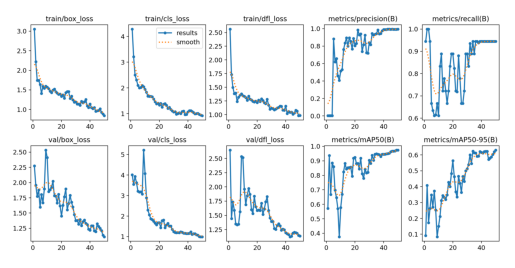

In [9]:
# Результаты обучения
TRAIN_RESULTS_PICTURE = PATH_DATASET + 'runs/detect/train2/results.png'
plt.imshow(Image.open(TRAIN_RESULTS_PICTURE))
plt.axis('off')
plt.show()


## Запуск модели на тестовой выборке

In [39]:
PATH_DATASET = '/content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/'
MODEL_PATH = PATH_DATASET + 'runs/detect/train2/weights/best.pt'
TEST_FILES = PATH_DATASET + 'test/'
PATH_PREDICT = PATH_DATASET + 'runs/detect/predict_yolov8n_50epochs/'

# Загрузка модели и получение результатов на тестовой выборке
model = YOLO(MODEL_PATH)
results = model(TEST_FILES, imgsz=640, show_labels=True, max_det=1, save=True, name=PATH_PREDICT)



image 1/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/10.jpg: 640x480 1 arm_tag, 6.9ms
image 2/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/13.jpg: 640x480 1 arm_tag, 16.0ms
image 3/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/22.jpg: 640x480 1 arm_tag, 6.5ms
image 4/4 /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/test/test.jpg: 640x480 1 arm_tag, 6.6ms
Speed: 3.2ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/drive/MyDrive/uai/st1/glasses_dataset_yolo8/runs/detect/predict_yolov8n_50epochs


## Отрисовка результатов и обрезка на тестовой выборке

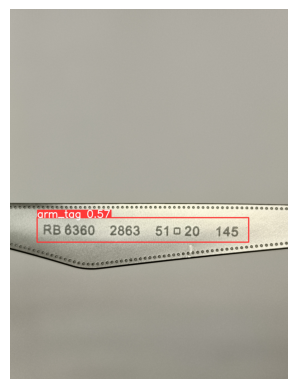

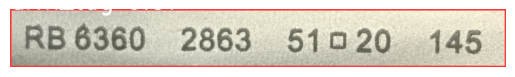

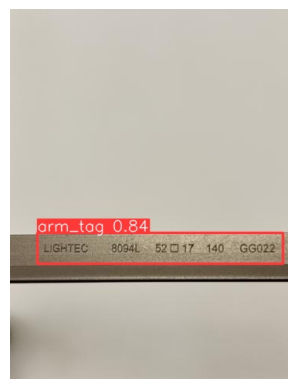

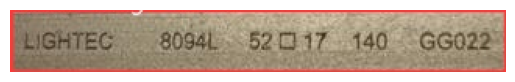

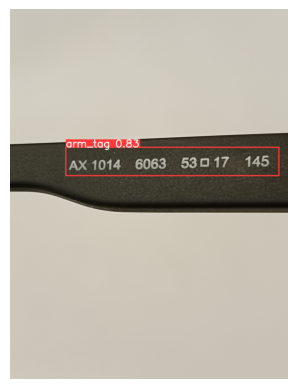

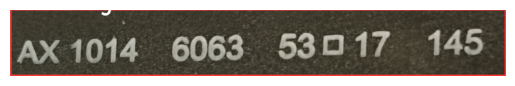

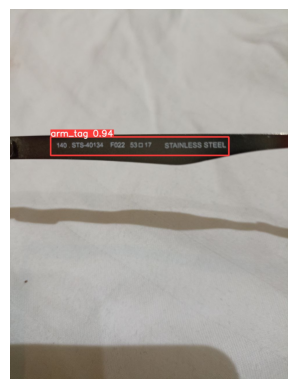

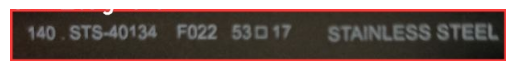

In [43]:
from pathlib import Path
%matplotlib inline

# Функция для отрисовки  изображения
def display_img(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Отрисовка результатов на полном изображении, обрезка и сохранение обрезанных изображений
predicted_images = glob.glob(PATH_PREDICT + '*.jpg')

img_num = 0
for img in predicted_images:
  img_to_show = Image.open(img)
  display_img(img_to_show)
  x_min, y_min, x_max, y_max = results[img_num].boxes.data[0][:4]
  cropped_img = img_to_show.crop((int(x_min), int(y_min), int(x_max), int(y_max)))
  display_img(cropped_img)
  path = Path(img)
  cropped_name = PATH_PREDICT + 'cropped_' + path.name
  cropped_img.save(cropped_name)
  img_num+= 1

## Чтение текста из рамок и поиск распознанного текста в таблице атрибутов

In [55]:
# Функция загрузки файла с атрибутами оправ и формированием списка атрибутов
def frames_attr():
  ATTR_FRAMES_FILE = PATH_DATASET + 'Атрибуты_3.xlsx'
  excel_attr = pd.read_excel(ATTR_FRAMES_FILE, names=['Num', 'empty', 'Attr_full','Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5'], index_col=0)
  df = pd.DataFrame(excel_attr)
  df = df.dropna(subset=['Attr_full'])
  attr_list = df['Attr_full'].tolist()
  attr_list_cleaned = ["".join(s.split()) for s in attr_list]
  return attr_list_cleaned

# Функция для отрисовки  изображения
def display_img(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

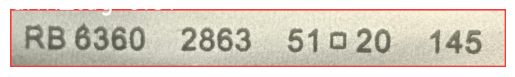

Распознанный текст:  RB6360 2863 51020 145
Текст для поиска в списке атрибутов: RB6360286351020145
В таблице атрибутов под порядковым номером  10  найден текст:  RB6360286351*20145   Индекс сходства 94


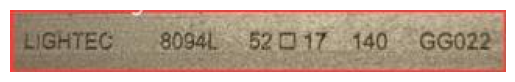

Распознанный текст:  “LGH $094L 52017 140 - GGO22
Текст для поиска в списке атрибутов: “LGH$094L52017140-GGO22
В таблице атрибутов под порядковым номером  13  найден текст:  LIGHTEC8094L52*17140GG022   Индекс сходства 77


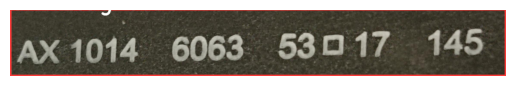

Распознанный текст:  AX 1014 6063 53017 145
Текст для поиска в списке атрибутов: AX1014606353017145
В таблице атрибутов под порядковым номером  22  найден текст:  AX1014606353*17145   Индекс сходства 94


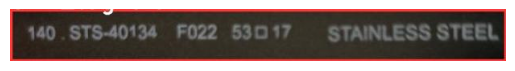

Распознанный текст:  140 .STS-40134 F022 53017 STAINLESS STEEL
Текст для поиска в списке атрибутов: 140.STS-40134F02253017STAINLESSSTEEL
В таблице атрибутов под порядковым номером  67  найден текст:  WE514505250*18140   Индекс сходства 50


In [57]:
# Распознавание текста и поиск наилучшего совпадения из списка
PATH_PREDICT = PATH_DATASET + 'runs/detect/predict_yolov8n_50epochs/'

attributes_cleaned = frames_attr()

images_for_extraction = glob.glob(PATH_PREDICT + 'cropped*.jpg')

for img in images_for_extraction:
  img_to_show = Image.open(img)
  display_img(img_to_show)
#  print('size=', img_to_show.size)

  if img_to_show.size[0] > 1000:
    img_to_show = img_to_show.resize((600, 68))
  if img_to_show.size[0] < 400:
    img_to_show = img_to_show.resize((400, 42))

  extracted_text = pytesseract.image_to_string(img_to_show).strip()
  print('Распознанный текст: ', extracted_text)

  text_cleaned = "".join(extracted_text.split())
  a = process.extractOne(text_cleaned, attributes_cleaned)  # находит совпадение текста с лучшим индексом сходства в списке атрибутов
  row_num = attributes_cleaned.index(a[0])

  print('Текст для поиска в списке атрибутов:', text_cleaned)
  print('В таблице атрибутов под порядковым номером ', row_num+1, ' найден текст: ',a[0], ' ', 'Индекс сходства', a[1])
  print('='*30)


  # imgcv2 = cv2.imread(img)
  # gray = cv2.cvtColor(imgcv2, cv2.COLOR_BGR2GRAY)
  # display_img(gray)
  # print('size=', gray.size)
  # extracted_text = pytesseract.image_to_string(gray)
  # print(extracted_text)
